# Recommendation System Analysis and Modeling

This project aims to build a personalized recommendation system for an e-commerce platform using historical user interaction data. By analyzing behavioral patterns such as views, add-to-cart actions, and transactions, the system predicts relevant product properties and detects abnormal user activity to improve recommendation accuracy. The ultimate goal is to enhance user experience, boost conversions, and support data-driven business decisions through a scalable and efficient solution.

## File Extraction

In [ ]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

In [ ]:
import os
import zipfile

def extract_all_zip_recursive(zip_path, extract_to):
    def _extract(zip_path, extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)


        for root, _, files in os.walk(extract_dir):
            for file in files:
                full_path = os.path.join(root, file)
                if zipfile.is_zipfile(full_path):
                    new_extract_dir = os.path.splitext(full_path)[0]
                    os.makedirs(new_extract_dir, exist_ok=True)
                    _extract(full_path, new_extract_dir)


    os.makedirs(extract_to, exist_ok=True)
    _extract(zip_path, extract_to)


# Changing the location of the files to be unzipped
zip_file = 'TMP.zip'
output_dir = 'rec_data'

extract_all_zip_recursive(zip_file, output_dir)

In [ ]:
def load_multiple_csvs_from_zip(data):
    """
    Loads all CSV files from a ZIP archive into a dictionary of pandas DataFrames.
    """
    dataframes = {}

    with zipfile.ZipFile(data.zip, 'r') as zip_ref:
        # Loop through all files in the ZIP
        for filename in zip_ref.namelist():
            # Only process .csv files
            if filename.endswith('.csv'):
                with zip_ref.open(data) as file:
                    df = pd.read_csv(data)
                    dataframes[data] = df
                    print(f"Loaded {data}: {df.shape[0]} rows, {df.shape[1]} columns")

    return dataframes

#### Loading event csv

In [ ]:
events_ddf = dd.read_csv ('events.csv',
    dtype={'timestamp': 'int64', 'visitorid': 'object', 'event': 'object', 'itemid': 'object', 'transactionid': 'object'}
)

# Converting timestamp to datetime format
events_ddf['datetime'] = dd.to_datetime(events_ddf['timestamp'], unit='ms')

events_ddf.head()

,timestamp,visitorid,event,itemid,transactionid,datetime
0,1433221332117,257597,view,355908,<NA>,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,<NA>,2015-06-02 05:50:14.164
2,1433221999827,111016,view,318965,<NA>,2015-06-02 05:13:19.827
3,1433221955914,483717,view,253185,<NA>,2015-06-02 05:12:35.914
4,1433221337106,951259,view,367447,<NA>,2015-06-02 05:02:17.106


In [ ]:
events_ddf.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 6 entries, timestamp to datetime
dtypes: datetime64[ns](1), float64(1), string(4)

In [ ]:
events_ddf.isnull().sum()

Dask Series Structure:
npartitions=1
datetime     int64
visitorid      ...
Dask Name: sum, 8 expressions
Expr=(~ NotNull(frame=Assign(frame=ArrowStringConversion(frame=FromMapProjectable(f475aa0))))).sum()

In [ ]:
print(events_ddf.columns)

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid',
       'datetime'],
      dtype='object')


In [ ]:
events_ddf['event'].value_counts()

Dask Series Structure:
npartitions=1
    int64[pyarrow]
               ...
Dask Name: valuecounts, 7 expressions
Expr=Assign(frame=ArrowStringConversion(frame=FromMapProjectable(f475aa0)))['event'].valuecounts(split_out=True)

#### Loading item properties csvs

In [15]:
item_props_ddf_1 = dd.read_csv('item_properties_part1.csv',
                               names=['timestamp', 'itemid', 'property', 'value'],
                               dtype=str)

item_props_ddf_2 = dd.read_csv('item_properties_part2.csv',
                               names=['timestamp', 'itemid', 'property', 'value'],
                               dtype=str)

item_props_ddf = dd.concat([item_props_ddf_1, item_props_ddf_2])
item_props_ddf.head()

,timestamp,itemid,property,value
0,timestamp,itemid,property,value
1,1435460400000,460429,categoryid,1338
2,1441508400000,206783,888,1116713 960601 n277.200
3,1439089200000,395014,400,n552.000 639502 n720.000 424566
4,1431226800000,59481,790,n15360.000


#### Loading category_tree csv

In [ ]:
category_tree_ddf = dd.read_csv('category_tree.csv',
    names=['categoryid', 'parentid'],
    dtype=str
)

category_tree_ddf.head()

,categoryid,parentid
0,categoryid,parentid
1,1016,213
2,809,169
3,570,9
4,1691,885


In [18]:
# Filter out rows where property is 'categoryid' or 'available'
df_item_properties_filtered = item_props_ddf[
    item_props_ddf['property'].isin(['categoryid', 'available'])
]

# Save to CSV
df_item_properties_filtered.to_csv('concat_properties.csv', index=False)


print(f"Filtered dataset saved.")
print(f"Filtered dataset saved with {len(df_item_properties_filtered)} rows.")

Filtered dataset saved.
Filtered dataset saved with 2291853 rows.


In [21]:
!pip install duckdb
import duckdb

In [26]:
# Convert Dask DataFrames to pandas DataFrames before registering
events_df = events_ddf.compute()
item_props_filtered_df = df_item_properties_filtered.compute()

# Register in DuckDB
duckdb.register('events', events_df)
duckdb.register('item_props_filtered', item_props_filtered_df)

# Merge & pivot categoryid and available
df_merged = duckdb.query("""
WITH props AS (
    SELECT
        itemid,
        CAST(timestamp AS BIGINT) as timestamp, -- Cast timestamp to BIGINT
        MAX(CASE WHEN property = 'categoryid' THEN value END) AS categoryid,
        MAX(CASE WHEN property = 'available' THEN value END) AS available
    FROM item_props_filtered
    GROUP BY itemid, timestamp
),
latest_props AS (
    SELECT *
    FROM (
        SELECT
            e.*,
            p.categoryid,
            p.available,
            ROW_NUMBER() OVER (
                PARTITION BY e.itemid, e.timestamp
                ORDER BY p.timestamp DESC
            ) AS rn
        FROM events e
        LEFT JOIN props p
        ON e.itemid = p.itemid
        AND p.timestamp <= e.timestamp
    )
    WHERE rn = 1
)
SELECT * EXCLUDE (rn)
FROM latest_props
""").to_df()

# Save merged file
df_merged.to_csv("merged_events_properties.csv", index=False)

print("Merge complete. Shape:", df_merged.shape)
display(df_merged.head())

/tmp/ipython-input-102997134.py:6: FutureWarning: ArrowStringArray._data is a deprecated and will be removed in a future version, use ._pa_array instead
  duckdb.register('events', events_df)
/tmp/ipython-input-102997134.py:6: FutureWarning: ArrowStringArray._data is a deprecated and will be removed in a future version, use ._pa_array instead
  duckdb.register('events', events_df)
/tmp/ipython-input-102997134.py:6: FutureWarning: ArrowStringArray._data is a deprecated and will be removed in a future version, use ._pa_array instead
  duckdb.register('events', events_df)
/tmp/ipython-input-102997134.py:7: FutureWarning: ArrowStringArray._data is a deprecated and will be removed in a future version, use ._pa_array instead
  duckdb.register('item_props_filtered', item_props_filtered_df)
/tmp/ipython-input-102997134.py:7: FutureWarning: ArrowStringArray._data is a deprecated and will be removed in a future version, use ._pa_array instead
  duckdb.register('item_props_filtered', item_props_f

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Merge complete. Shape: (2755607, 7)


,timestamp,visitorid,event,itemid,transactionid,categoryid,available
0,1436980140951,924298,view,1000,None,None,None
1,1437113431005,953188,view,100004,None,None,1
2,1437525564601,801697,view,100004,None,None,1
3,1437931270401,1077173,view,100004,None,None,1
4,1441396471282,1186616,view,100004,None,None,1


In [ ]:

events_ddf.shape

(<dask_expr.expr.Scalar: expr=Assign(frame=ArrowStringConversion(frame=FromMapProjectable(f475aa0))).size() // 6, dtype=int64>,
 6)

In [ ]:
# Count of unique visitors
events_ddf['visitorid'].nunique().compute()

np.int64(1407580)

In [ ]:
# Count of unique items
events_ddf['itemid'].nunique().compute()

np.int64(235061)

In [ ]:
# Event type distribution
events_ddf['event'].value_counts().compute()

event
addtocart        69332
transaction      22457
view           2664312
Name: count, dtype: int64[pyarrow]

In [ ]:
# Date range
events_ddf['datetime'].min().compute(), events_ddf['datetime'].max().compute()

(Timestamp('2015-05-03 03:00:04.384000'),
 Timestamp('2015-09-18 02:59:47.788000'))

In [ ]:
###Date conversions
import dask.dataframe as dd
import pandas as pd

# Convert timestamp to datetime (in milliseconds)
events_ddf['datetime'] = dd.to_datetime(events_ddf['timestamp'], unit='ms')

# Extracting week start (Monday)
events_ddf['week_start'] = events_ddf['datetime'].dt.to_period('W').dt.start_time

In [ ]:
weekly_counts = events_ddf.groupby('week_start')['event'].count().compute()
print (weekly_counts)

week_start
2015-04-27     13683
2015-05-04    133775
2015-05-11    148861
2015-05-18    152514
2015-05-25    141819
2015-06-01    146445
2015-06-08    131852
2015-06-15    145976
2015-06-22    141688
2015-06-29    139233
2015-07-06    161845
2015-07-13    152243
2015-07-20    175437
2015-07-27    144337
2015-08-03    128559
2015-08-10    120763
2015-08-17    126924
2015-08-24    127810
2015-08-31    119057
2015-09-07    138789
2015-09-14     64491
Name: event, dtype: int64


In [ ]:
## 21 weeks in total from the week count
## ~5 months in total

## Exploratory Data Analysis

## Business Questions

1. What are the most viewed, added to cart, and purchased products overall?
2. What is the average conversion rate from view → cart → purchase?
3. Which categories drive the most purchases?
4. What are the top products users tend to add to cart after viewing?
5. What are the top 10 most viewed items?
6. Are there user behavior patterns that indicate bots or abnormal activity?
7. What proportion of items are currently available versus unavailable in the inventory?
8. What are the popular 10 item categories?
9. How has the number of recorded events changed over time?

#### Q1: What are the most viewed, added to cart, and purchased products overall? (Overall Event Type Distribution)

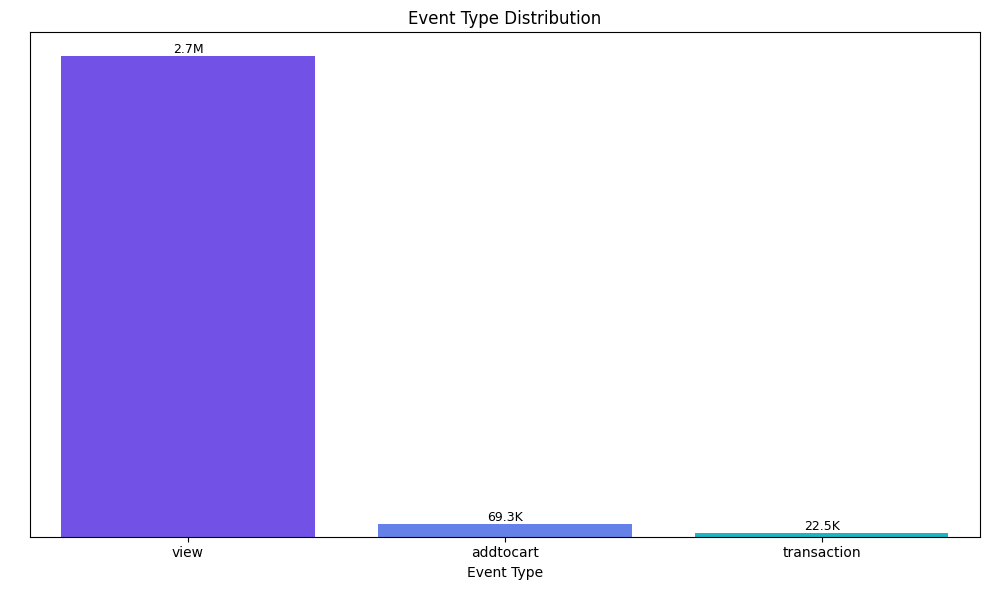

In [ ]:
# Computing and sorting event counts
event_counts = events_ddf['event'].value_counts().compute().sort_values(ascending=False)

# Converting to DataFrame for Seaborn
event_df = pd.DataFrame({
    'event': event_counts.index,
    'count': event_counts.values
})
# Custom color palette
colors = ["#6439FF", "#4F75FF", "#00CCDD"]

# Creating the barplot using hue for color mapping
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=event_df,
    x='event',
    y='count',
    hue='event',  # Required for palette usage
    palette=colors[:len(event_df)],
    legend=False  # Hides legend since we're only using hue for color control
)


# Removing y-axis ticks
plt.yticks([])

# Formatting function for value labels
def format_value(val):
    if val >= 1_000_000:
        return f"{val / 1_000_000:.1f}M"
    elif val >= 1_000:
        return f"{val / 1_000:.1f}K"
    else:
        return str(val)

# Adding data labels above bars
for i, val in enumerate(event_df['count']):
    ax.text(i, val, format_value(val), ha='center', va='bottom', fontsize=9)

# Titles and axis labels
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel(" ")
plt.savefig('event_type_distro.png')  # Save image

plt.tight_layout()
plt.show()

#### Q2: What is the average conversion rate from view → cart → purchase?

Conversion rates:
 event
view_to_cart        0.013632
cart_to_purchase    0.266650
dtype: float64


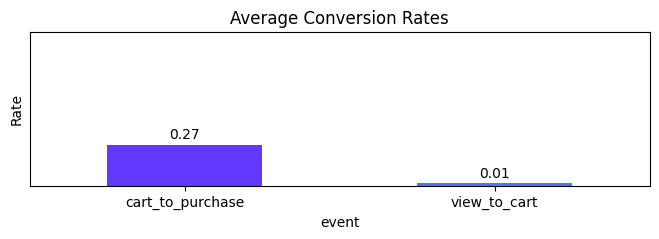

In [ ]:
# Counting events by visitor
visitor_event_counts = (
    events_ddf.groupby(['visitorid', 'event'])['itemid'].count().compute()
)
visitor_event_counts = visitor_event_counts.unstack().fillna(0)


# Ensuring all needed columns exist
for col in ['view', 'addtocart', 'transaction']:
    if col not in visitor_event_counts.columns:
        visitor_event_counts[col] = 0

# Computing conversion rates
visitor_event_counts['view_to_cart'] = visitor_event_counts['addtocart'] / visitor_event_counts['view'].replace(0, np.nan)
visitor_event_counts['cart_to_purchase'] = visitor_event_counts['transaction'] / visitor_event_counts['addtocart'].replace(0, np.nan)

# Average conversion rates calculation
conversion_rates = visitor_event_counts[['view_to_cart', 'cart_to_purchase']].mean(skipna=True)

print("Conversion rates:\n", conversion_rates)

conversion_rates = conversion_rates.sort_values(ascending=False)


# Plot
ax = conversion_rates.plot(kind='bar', color=['#6439FF', '#4F75FF'], figsize=(8, 2))
plt.title('Average Conversion Rates')
plt.ylabel('Rate')
plt.ylim(0, 1)  # Conversion rates typically between 0 and 1
plt.xticks(rotation=0)
plt.savefig('avg_coversion_rates.png')  # Save image

# Removing y-axis ticks
ax.yaxis.set_ticks([])

# Adding data labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # X coordinate: center of bar
        height + 0.02,                  # Y coordinate: just above the bar
        f"{height:.2f}",                # Label text formatted to 2 decimals
        ha='center', va='bottom'
    )

plt.show()

#### Q3: Which categories drive the most purchases?

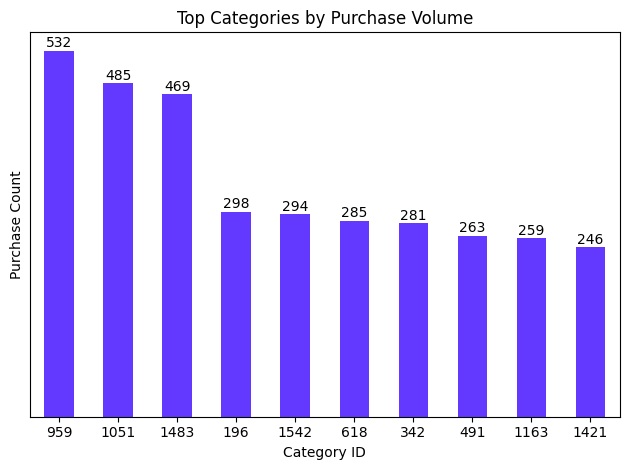

In [ ]:
transactions = events_ddf[events_ddf['event'] == 'transaction']

# Item → category mapping
category_items = item_props_ddf[item_props_ddf['property'] == 'categoryid']
latest_category = category_items.sort_values('timestamp').drop_duplicates(subset='itemid', keep='last')

# Merging
merged = transactions.merge(latest_category[['itemid', 'value']], on='itemid', how='left')
merged = merged.rename(columns={'value': 'categoryid'})

# Computing value counts first, then sort and select top 10
category_purchase_counts = merged['categoryid'].value_counts().compute().sort_values(ascending=False).head(10)

# Plot with data labels
ax = category_purchase_counts.plot(kind='bar', color='#6439FF'
)
plt.title('Top Categories by Purchase Volume')
plt.ylabel('Purchase Count')
plt.xlabel('Category ID')
plt.xticks(rotation=0)
plt.savefig('high_purchase_categories.png')  # Save image

# Removing y-axis ticks
ax.yaxis.set_ticks([])

# Adding data labels on top of each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f'{int(height):,}',  # comma formatting
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

#### Q4: What are the top products users tend to add to cart after viewing?

In [ ]:
views = events_ddf[events_ddf['event'] == 'view']
carts = events_ddf[events_ddf['event'] == 'addtocart']

# Grouping by visitorid and aggregate itemid as list
user_views = views.groupby('visitorid')['itemid'].apply(list, meta=('itemid', 'object'))
user_carts = carts.groupby('visitorid')['itemid'].apply(list, meta=('itemid', 'object'))

# Computing both before iterating
user_views = user_views.compute()
user_carts = user_carts.compute()

co_occurrence = {}

for user in user_views.index:
    viewed = set(user_views[user])
    if user in user_carts.index:
        added = set(user_carts[user])
        for v in viewed:
            for a in added:
                co_occurrence[(v, a)] = co_occurrence.get((v, a), 0) + 1

# Sort pairs
co_occurrence_sorted = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top View → Add to Cart Product Pairs:")
for pair, count in co_occurrence_sorted:
    print(f"Viewed: {pair[0]}, Added to Cart: {pair[1]} → {count} times")

Top View → Add to Cart Product Pairs:
Viewed: 461686, Added to Cart: 461686 → 254 times
Viewed: 409804, Added to Cart: 409804 → 124 times
Viewed: 312728, Added to Cart: 312728 → 117 times
Viewed: 29196, Added to Cart: 29196 → 98 times
Viewed: 218794, Added to Cart: 461686 → 96 times
Viewed: 320130, Added to Cart: 320130 → 91 times
Viewed: 7943, Added to Cart: 7943 → 84 times
Viewed: 48030, Added to Cart: 48030 → 79 times
Viewed: 257040, Added to Cart: 257040 → 72 times
Viewed: 17478, Added to Cart: 17478 → 64 times


#### Q5: What are the top 10 most viewed items?

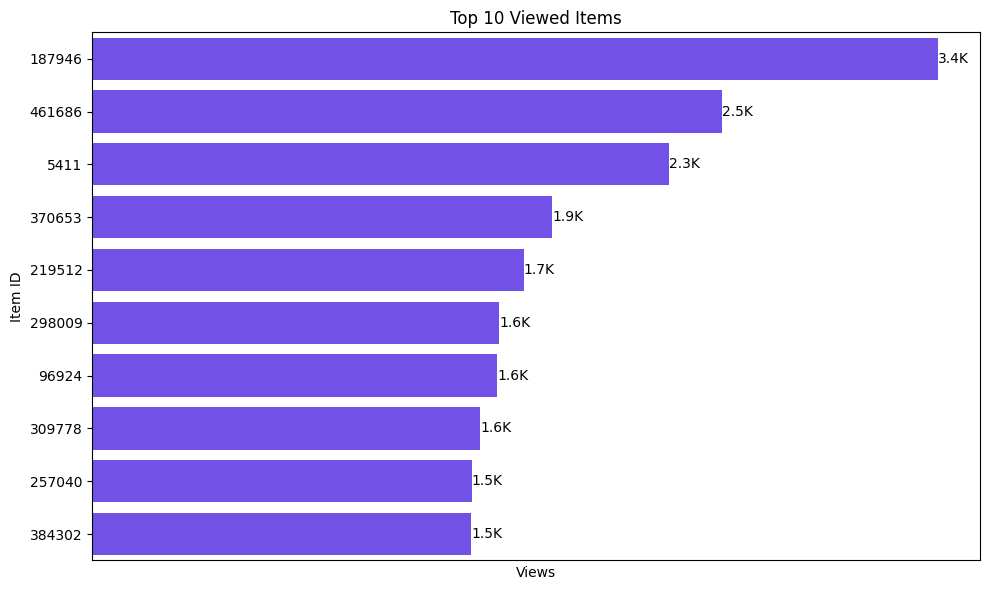

In [ ]:
top_viewed_items = events_ddf[events_ddf['event'] == 'view']['itemid'].value_counts().nlargest(10).compute()

# Create barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(y=top_viewed_items.index, x=top_viewed_items.values, color ='#6439FF')

# Title and labels
plt.title("Top 10 Viewed Items")
plt.xlabel("Views")
plt.ylabel("Item ID")  # Remove y-axis label
plt.savefig('top_viewed_items.png')  # Save image

# Remove y-ticks
ax.set_xticks([])

# Add data labels with K/M formatting
for i, value in enumerate(top_viewed_items.values):
    if value >= 1_000_000:
        label = f"{value / 1_000_000:.1f}M"
    elif value >= 1_000:
        label = f"{value / 1_000:.1f}K"
    else:
        label = str(value)

    ax.text(value, i, label, va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

#### Q6: Are there user behavior patterns that indicate bots or abnormal activity?

Number of abnormal users detected: 155


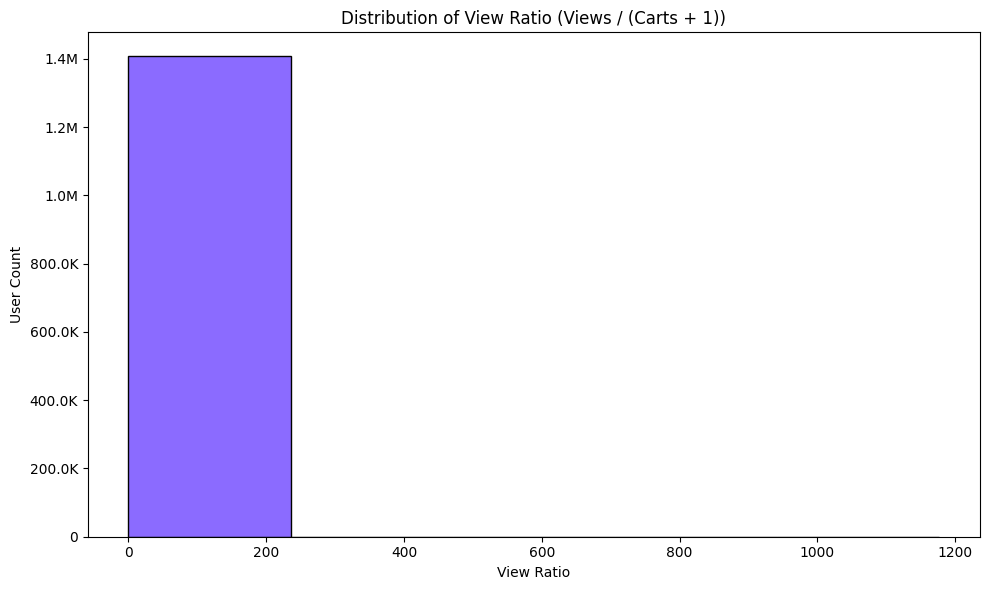

In [ ]:
from matplotlib.ticker import FuncFormatter

# Counting events per visitor per event type
user_activity = events_ddf.groupby(['visitorid', 'event']).size().compute()

# Converting to DataFrame format and unstacking
user_activity = user_activity.unstack(fill_value=0)

# Computing view-to-cart ratio
user_activity['view_ratio'] = user_activity.get('view', 0) / (user_activity.get('addtocart', 0) + 1)

# Identifying abnormal users (high views, few/no carts)
abnormal_users = user_activity[user_activity['view_ratio'] > 100]

# Reporting count
print(f"Number of abnormal users detected: {len(abnormal_users)}")

# Plot
# Formatter for K/M values
def format_with_suffix(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x/1_000:.1f}K'
    else:
        return str(int(x))

plt.figure(figsize=(10, 6))
sns.histplot(user_activity['view_ratio'], bins=5, color='#6439FF')

plt.title('Distribution of View Ratio (Views / (Carts + 1))')
plt.xlabel('View Ratio')
plt.ylabel('User Count')
plt.savefig('distro_view_ratio.png')  # Save image

# Apply custom formatter to y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_suffix))

plt.tight_layout()
plt.show()

In [ ]:
# Plot with KDE

Number of abnormal users detected: 155


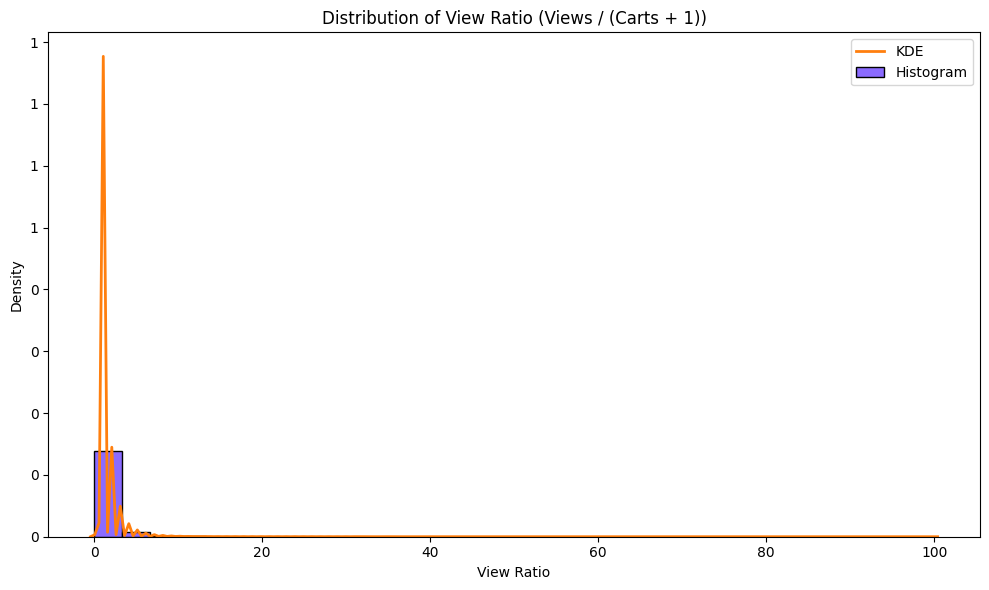

In [ ]:
# Counting events per visitor per event type
user_activity = events_ddf.groupby(['visitorid', 'event']).size().compute()

# Converting to DataFrame format and unstacking
user_activity = user_activity.unstack(fill_value=0)

# Computing view-to-cart ratio
user_activity['view_ratio'] = user_activity.get('view', 0) / (user_activity.get('addtocart', 0) + 1)

# Identify abnormal users
abnormal_users = user_activity[user_activity['view_ratio'] > 100]
print(f"Number of abnormal users detected: {len(abnormal_users)}")

# Filter out extreme values for better KDE visibility (optional)
filtered_view_ratios = user_activity[user_activity['view_ratio'] <= 100]['view_ratio']

# Formatter for K/M values
def format_with_suffix(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x/1_000:.1f}K'
    else:
        return str(int(x))

# Plot with KDE
plt.figure(figsize=(10, 6))
sns.histplot(filtered_view_ratios, bins=30, color='#6439FF', stat='density', label='Histogram')
sns.kdeplot(filtered_view_ratios, color='#FF7F0E', linewidth=2, label='KDE')

plt.title('Distribution of View Ratio (Views / (Carts + 1))')
plt.xlabel('View Ratio')
plt.ylabel('Density')
plt.savefig('distro_view_ratio_KDE.png')  # Save image

# Format y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_suffix))

# Add legend and layout
plt.legend()
plt.tight_layout()
plt.show()

| **View Ratio** | **Behavior**                               | **Interpretation / Action**                                  |
| -------------- | ------------------------------------------ | ------------------------------------------------------------ |
| **0–1**        | Adding to cart almost every item they view | Very high intent; possibly returning or loyal users          |
| **1–5**        | Fairly engaged users                       | Normal, healthy user behavior                                |
| **5–20**       | Browsing a lot, selecting fewer items      | Normal behavior; maybe indecisive or looking for best option |
| **20–100**     | Lots of browsing, few adds to cart         | Could be UX issues, product discovery friction               |
| **100–1,200**  | Very high browsing, almost no cart actions | Likely bots, scrapers, or very low-intent users              |


#### Q7: What proportion of items are currently available versus unavailable in the inventory?

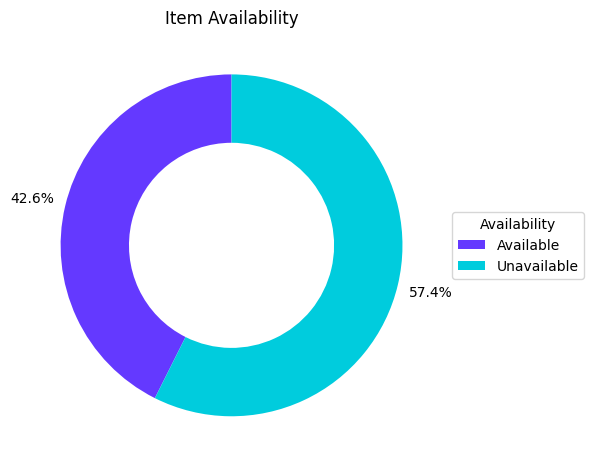

In [ ]:
import numpy as np

available_props = item_props_ddf[item_props_ddf['property'] == 'available']
available_values = available_props['value'].value_counts().compute()
labels = ['Available', 'Unavailable']

# Donut chart setup
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts = ax.pie(
    available_values,
    colors =['#6439FF','#00CCDD'],
    labels=None,
    startangle=90,
    wedgeprops=dict(width=0.4)
)

# Adding percentage labels to outer edge of each wedge
total = available_values.sum()
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))
    percentage = available_values.iloc[i] / total * 100
    ax.text(
        1.2 * x, 1.2 * y, f"{percentage:.1f}%",  # 1.2 to push label outward
        ha='center', va='center', fontsize=10
    )

# Legend
ax.legend(wedges, labels, title="Availability", loc="center left", bbox_to_anchor=(1, 0.5))

# Title
ax.set_title("Item Availability")
plt.savefig('item_availabilty.png')  # Save image

plt.tight_layout()
plt.show()

#### Q8: What are the popular 10 item categories?

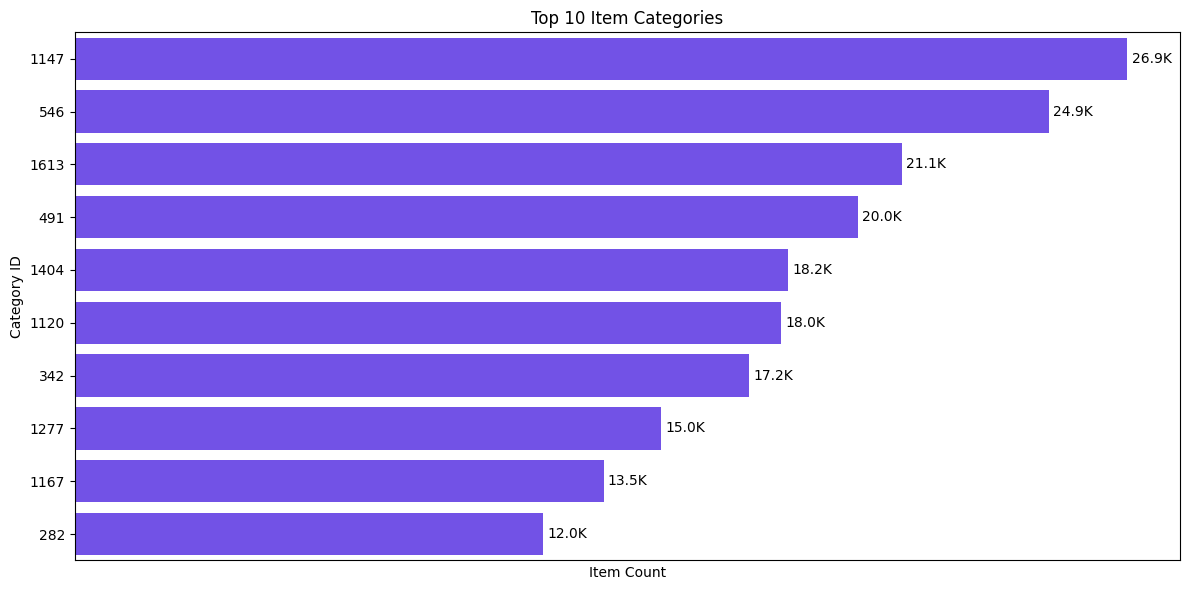

In [ ]:
category_props = item_props_ddf[item_props_ddf['property'] == 'categoryid']
top_categories = category_props['value'].value_counts().nlargest(10).compute()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_categories.values, y=top_categories.index, color ='#6439FF')

plt.title("Top 10 Item Categories")
plt.xlabel("Item Count")
plt.ylabel("Category ID")
plt.savefig('top_item_categories.png')  # Save image


ax.set_xticks([])  # Remove x ticks

def format_value(val):
    if val >= 1_000_000:
        return f"{val / 1_000_000:.1f}M"
    elif val >= 1_000:
        return f"{val / 1_000:.1f}K"
    else:
        return str(val)

# Adding data labels
for i, value in enumerate(top_categories.values):
    ax.annotate(
        format_value(value),
        xy=(value, i),
        xytext=(3, 0),
        textcoords='offset points',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

plt.tight_layout()
plt.show()

#### Q9: How has the number of recorded events changed over time? (Monthly, Weekly, Daily)

#### Monthly trends of events over time

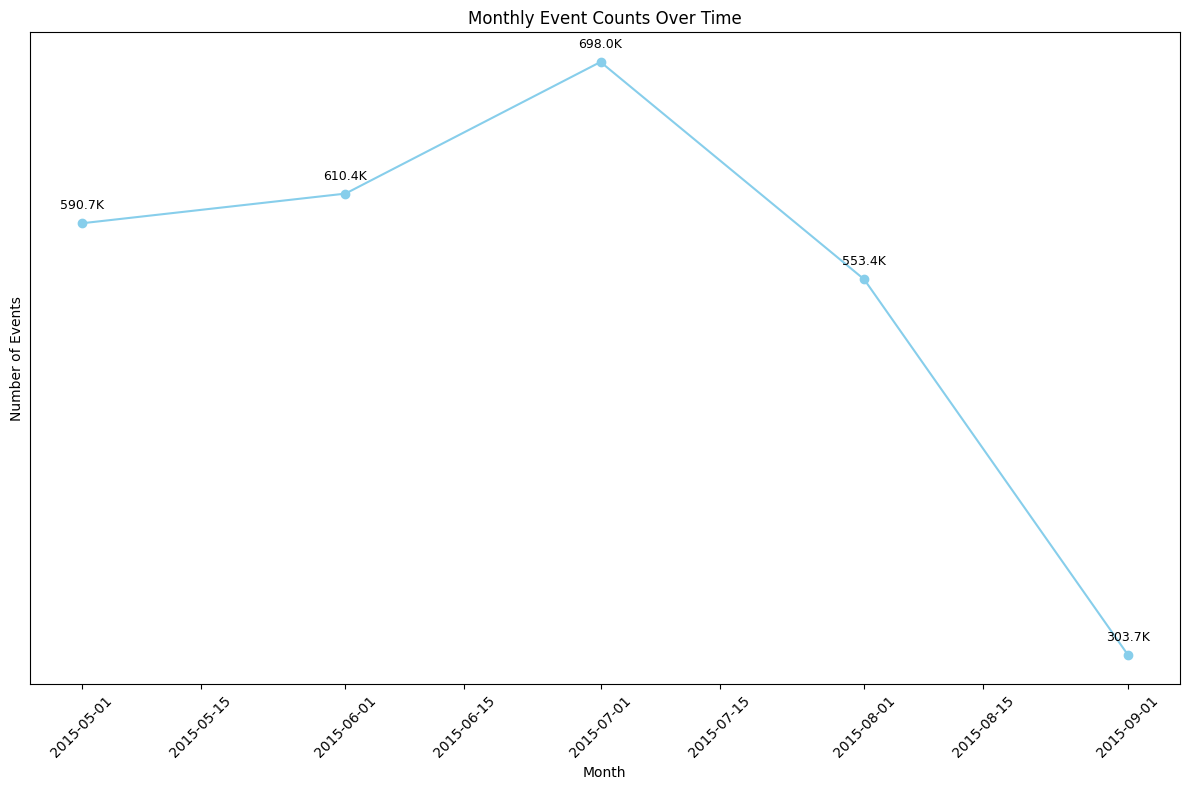

In [ ]:
events_ddf['month'] = events_ddf['datetime'].dt.to_period('M').dt.to_timestamp()

# Grouping by month and computing event counts
monthly_events = events_ddf.groupby('month').size().compute()
monthly_events.sort_index(inplace=True)

# Formatting value symbols
def format_value(val):
    if val >= 1_000_000:
        return f"{val / 1_000_000:.1f}M"
    elif val >= 1_000:
        return f"{val / 1_000:.1f}K"
    else:
        return str(val)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(monthly_events.index, monthly_events.values, marker='o', color='skyblue')
plt.title("Monthly Event Counts Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Events")
plt.yticks([])  # Removing y-axis ticks
plt.grid(False)  # Removing grid lines
plt.xticks(rotation=45)
plt.savefig('monthly_events.png')  # Save image

# Annotating all points
for date, val in zip(monthly_events.index, monthly_events.values):
    plt.annotate(format_value(val), (date, val),
                 textcoords="offset points", xytext=(0, 10), ha='center',
                 fontsize=9, color='black')

plt.tight_layout()
plt.show()

#### Weekly trends of events over time

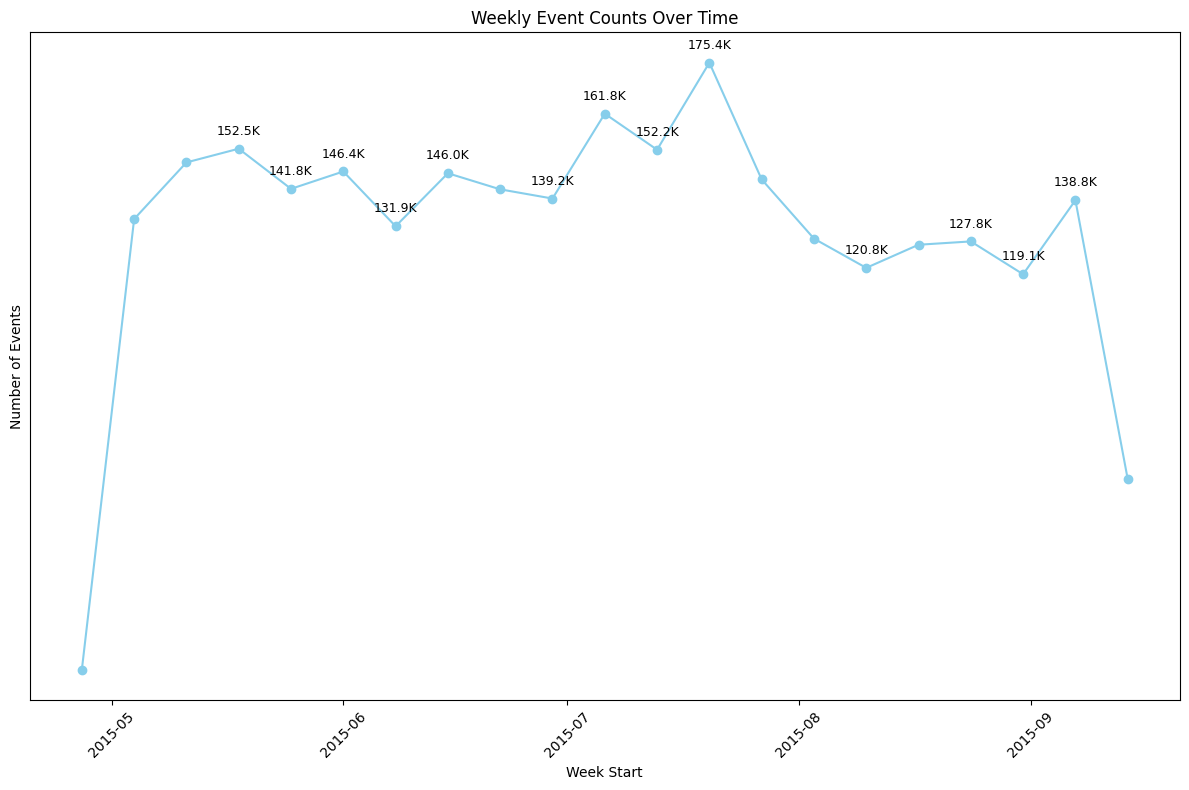

In [ ]:
weekly_counts.sort_index(inplace=True)

# Identifying peaks and dips
values = weekly_counts.values
indices = weekly_counts.index
peaks_dips = []

for i in range(1, len(values) - 1):
    if values[i] > values[i - 1] and values[i] > values[i + 1]:  # peak
        peaks_dips.append((indices[i], values[i]))
    elif values[i] < values[i - 1] and values[i] < values[i + 1]:  # dip
        peaks_dips.append((indices[i], values[i]))

# Formatting numbers with value symbols
def format_value(val):
    if val >= 1_000_000:
        return f"{val / 1_000_000:.1f}M"
    elif val >= 1_000:
        return f"{val / 1_000:.1f}K"
    else:
        return str(val)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(indices, values, marker='o', color='skyblue')
plt.title("Weekly Event Counts Over Time")
plt.xlabel("Week Start")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.yticks([])        # Removes y-axis ticks
plt.grid(False)       # Removes grid lines
plt.savefig('weekly_events.png')  # Save image

# Annotating only peaks and dips with formatted values
for date, val in peaks_dips:
    plt.annotate(format_value(val), (date, val),
                 textcoords="offset points", xytext=(0, 10), ha='center',
                 fontsize=9, color='black')

plt.tight_layout()
plt.show()

#### Daily trends of events over time

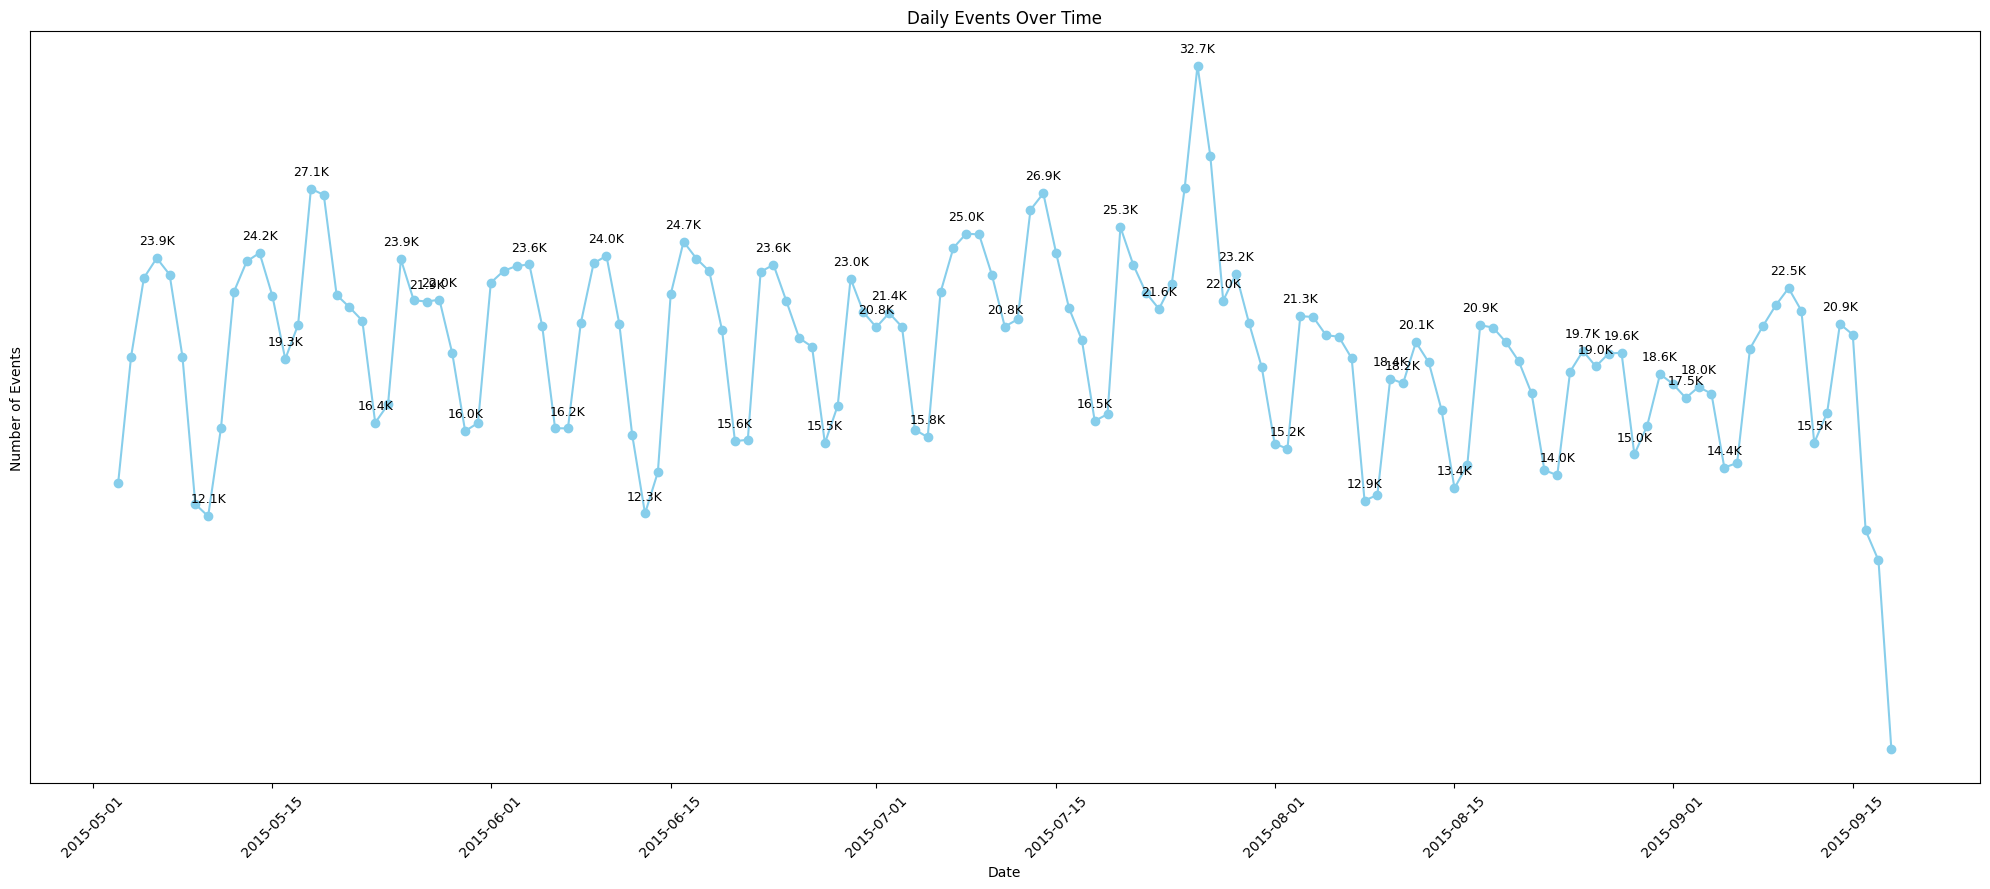

In [ ]:
events_ddf['date'] = events_ddf['datetime'].dt.date

# Grouping and conversion
daily_events = events_ddf.groupby('date').size().compute()
daily_events.sort_index(inplace=True)

# Identifying peaks and dips
values = daily_events.values
indices = daily_events.index
peaks_dips = []

for i in range(1, len(values) - 1):
    if values[i] > values[i - 1] and values[i] > values[i + 1]:  # peak
        peaks_dips.append((indices[i], values[i]))
    elif values[i] < values[i - 1] and values[i] < values[i + 1]:  # dip
        peaks_dips.append((indices[i], values[i]))

# Value formatting function (K/M)
def format_value(val):
    if val >= 1_000_000:
        return f"{val / 1_000_000:.1f}M"
    elif val >= 1_000:
        return f"{val / 1_000:.1f}K"
    else:
        return str(val)

# Plot
plt.figure(figsize=(20, 9))
plt.plot(indices, values, color='skyblue', marker='o')
plt.title("Daily Events Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.yticks([])  # Removes y-axis ticks
plt.grid(False)  # Removes grid lines
plt.xticks(rotation=45)
plt.savefig('daily_events.png')  # Save image

# Annotating peaks and dips with value symbols
for date, val in peaks_dips:
    plt.annotate(format_value(val), (date, val),
                 textcoords="offset points", xytext=(0, 10), ha='center',
                 fontsize=9, color='black')

plt.tight_layout()
plt.show()

## Task 1: Add-to-Cart Property Prediction

### Model Comparison and Evaluation

In [ ]:
### Setup and Feature Engineering (Same for both models)

In [ ]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from dask import delayed, compute

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Start Dask
client = Client()

# Load the Dask dataframe
events_ddf = dd.read_csv('events.csv',
    dtype={
        'timestamp': 'int64',
        'visitorid': 'object',
        'event': 'object',
        'itemid': 'object',
        'transactionid': 'object'
    }
)

# Sample a small number of visitors for efficiency (e.g. 5000 users)
with ProgressBar():
    unique_visitors = events_ddf['visitorid'].drop_duplicates().compute()
    sampled_visitors = unique_visitors.sample(n=5000, random_state=42)


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:36289
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42573'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46437'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:37375 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37375
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:38442
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:43857 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:43857
INFO:distributed.core:Starting established connection to tcp://127

In [ ]:
# Filter dataset for sampled users and relevant events
filtered_ddf = events_ddf[
    events_ddf['visitorid'].isin(sampled_visitors) &
    events_ddf['event'].isin(['view', 'addtocart', 'transaction'])
]

# Compute filtered data to pandas
filtered_df = filtered_ddf.compute()

In [ ]:
@delayed
def label_user_conversions(user_df):
    user_df = user_df.sort_values('timestamp').reset_index(drop=True)
    labels = [0] * len(user_df)

    for i, row in user_df.iterrows():
        if row['event'] != 'view':
            continue
        item = row['itemid']
        subsequent = user_df.iloc[i + 1:]
        saw_add = False
        for _, r in subsequent.iterrows():
            if r['itemid'] != item:
                continue
            if r['event'] == 'addtocart':
                saw_add = True
            elif saw_add and r['event'] == 'transaction':
                labels[i] = 1
                break
    user_df['leads_to_conversion'] = labels
    return user_df

# Group by visitor and delay-label each user
grouped = filtered_df.groupby('visitorid')
delayed_labeled = [label_user_conversions(group) for _, group in grouped]

# Run delayed computation in chunks
with ProgressBar():
    labeled_parts = compute(*delayed_labeled)
df_labeled = pd.concat(labeled_parts, ignore_index=True)

INFO:distributed.core:Event loop was unresponsive in Nanny for 4.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 4.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 4.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 3.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 3.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause tim

In [ ]:
### Model 1 — Logistic Regression with balanced class weights

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.

Classification Report:
              precision    recall  f1-score   support

        view       0.97      1.00      0.98      2270
   addtocart       0.00      0.00      0.00        66
 transaction       0.00      0.00      0.00        11

    accuracy                           0.97      2347
   macro avg       0.32      0.33      0.33      2347
weighted avg       0.94      0.97      0.95      2347



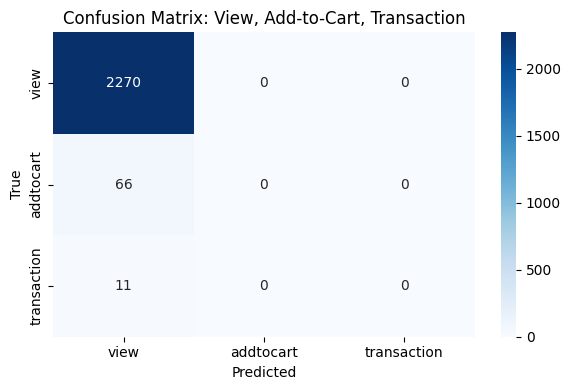

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Map event to integer labels (0=view, 1=addtocart, 2=transaction)
event_mapping = {'view': 0, 'addtocart': 1, 'transaction': 2}
df_labeled['event_code'] = df_labeled['event'].map(event_mapping)

# Feature engineering: view count per visitor/item pair
df_labeled['view_count_per_item'] = df_labeled.groupby(['visitorid', 'itemid'])['event'] \
    .transform(lambda x: (x == 'view').sum())

# Use all rows (view, addtocart, transaction)
X = df_labeled[['view_count_per_item']]  # You can add more features here
y = df_labeled['event_code']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train multiclass logistic regression
model = LogisticRegression(max_iter=1000, solver='liblinear', multi_class='ovr', class_weight='balanced')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=event_mapping.keys()))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=event_mapping.keys(),
            yticklabels=event_mapping.keys())
plt.title("Confusion Matrix: View, Add-to-Cart, Transaction")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
### Model 2 — XGBoost with SMOTE

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:47:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

        view       0.96      0.63      0.76       795
   addtocart       0.05      0.32      0.09        34
 transaction       0.00      0.00      0.00         3

    accuracy                           0.62       832
   macro avg       0.34      0.32      0.28       832
weighted avg       0.92      0.62      0.73       832



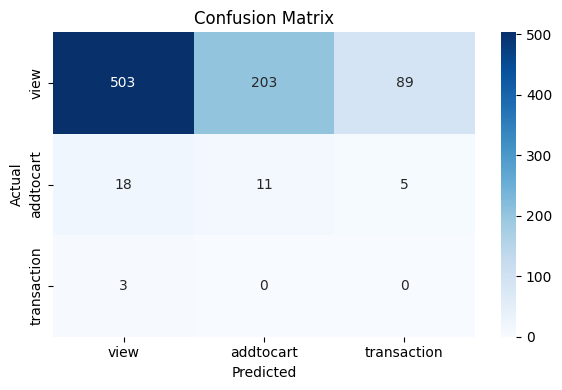

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Map event to label
event_mapping = {'view': 0, 'addtocart': 1, 'transaction': 2}
df_labeled['event_label'] = df_labeled['event'].map(event_mapping)

# Determine the label of the *next* event for each row
df_labeled['next_event'] = df_labeled.groupby('visitorid')['event'].shift(-1)
df_labeled['next_event_label'] = df_labeled['next_event'].map(event_mapping)

# Select only 'view' rows for training, and drop rows where the next event is not in event_mapping
df_view = df_labeled[df_labeled['event'] == 'view'].copy()
df_view = df_view.dropna(subset=['next_event_label'])


# Feature engineering: view count per visitor/item pair
df_view['view_count_per_item'] = df_view.groupby(['visitorid', 'itemid'])['event'] \
    .transform(lambda x: (x == 'view').sum())

# Features and target
X = df_view[['view_count_per_item']]  # use more features if available
y = df_view['next_event_label']       # must contain values 0, 1, 2

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

# Apply SMOTE (handle multiclass with k_neighbors)
min_class_size = y_train.value_counts().min()
k_neighbors = min(5, min_class_size - 1)

if k_neighbors > 0:
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
else:
    print("Warning: Smallest class has only one sample, cannot apply SMOTE.")
    X_train_resampled, y_train_resampled = X_train, y_train


# Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42,
                      objective='multi:softmax', num_class=len(event_mapping))
model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = model.predict(X_test)

# Classification report
target_names = [name for name, code in sorted(event_mapping.items(), key=lambda item: item[1])]
print(classification_report(
    y_test, y_pred, target_names=target_names
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
### XGBoost + SMOTE (Multiclass)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:48:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

        view       0.98      0.84      0.90       795
   addtocart       0.12      0.44      0.19        34
 transaction       0.03      0.33      0.06         3

    accuracy                           0.82       832
   macro avg       0.38      0.54      0.39       832
weighted avg       0.94      0.82      0.87       832



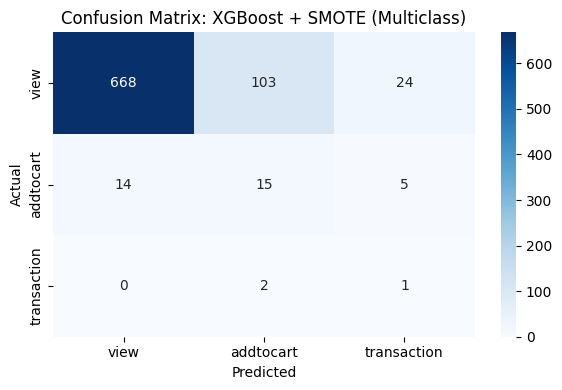

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Step 1: Feature engineering
df_labeled['view_count_per_item'] = df_labeled.groupby(['visitorid', 'itemid'])['event'] \
    .transform(lambda x: (x == 'view').sum())

df_labeled['item_total_views'] = df_labeled.groupby('itemid')['event'].transform(lambda x: (x == 'view').sum())
df_labeled['user_total_views'] = df_labeled.groupby('visitorid')['event'].transform(lambda x: (x == 'view').sum())
df_labeled['event_index'] = df_labeled.groupby('visitorid').cumcount()

# Map event types to integers: view=0, addtocart=1, transaction=2
event_mapping = {'view': 0, 'addtocart': 1, 'transaction': 2}
df_labeled['event_label'] = df_labeled['event'].map(event_mapping)

# Determine the label of the *next* event for each row
df_labeled['next_event'] = df_labeled.groupby('visitorid')['event'].shift(-1)
df_labeled['next_event_label'] = df_labeled['next_event'].map(event_mapping)

# Use only 'view' rows to predict the next event, and drop rows where the next event is not in event_mapping
df_view = df_labeled[df_labeled['event'] == 'view'].copy()
df_view = df_view.dropna(subset=['next_event_label'])


X = df_view[['view_count_per_item', 'item_total_views', 'user_total_views', 'event_index']]
y = df_view['next_event_label'].astype(int)  # Ensure target is integer type

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

# Step 3: Apply SMOTE to training data (handle multiclass with k_neighbors)
# Determine the number of neighbors for SMOTE based on the smallest class size
min_class_size = y_train.value_counts().min()
k_neighbors = min(5, min_class_size - 1) # SMOTE needs at least 2 samples

if k_neighbors > 0:
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
else:
    # If the smallest class has only one sample, SMOTE cannot be applied
    print("Warning: Smallest class has only one sample, cannot apply SMOTE.")
    X_train_resampled, y_train_resampled = X_train, y_train


# Step 4: Train XGBoost classifier (multiclass)
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    objective='multi:softmax', # For multiclass classification
    num_class=len(event_mapping) # Number of classes
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Step 5: Evaluate
y_pred = xgb_model.predict(X_test)

# Convert integer predictions and true labels back to event names for the report
target_names = [name for name, code in sorted(event_mapping.items(), key=lambda item: item[1])]
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.title("Confusion Matrix: XGBoost + SMOTE (Multiclass)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Saving the model
joblib.dump(xgb_model, "xgb_multiclass_model.pkl")

# Saving the event mapping
joblib.dump(event_mapping, "event_mapping.pkl")

['event_mapping.pkl']

In [ ]:
from google.colab import files
files.download("xgb_multiclass_model.pkl")
files.download("event_mapping.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
### Comparing ROC Curves

ROC stands for Receiver Operating Characteristic curve.

It’s a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

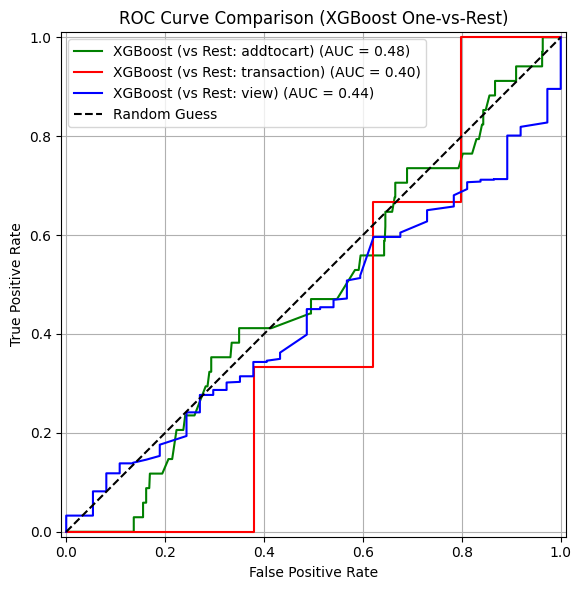

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

# Calculate predicted probabilities for the positive class (conversion = 1)
# Calculate predicted probabilities for the multiclass XGBoost model
# Ensure X_test has the same features as used in xgb_model.fit()
# Based on previous cell, the features are: 'view_count_per_item', 'item_total_views', 'user_total_views', 'event_index'
X_test_xgb = df_view[df_view.index.isin(X_test.index)][['view_count_per_item', 'item_total_views', 'user_total_views', 'event_index']]


# Let's plot ROC one-vs-rest for 'addtocart' vs rest and 'transaction' vs rest for XGBoost.

fig, ax = plt.subplots(figsize=(8, 6))


# Plot ROC for XGBoost (One-vs-Rest for each class)
# For 'addtocart' (label 1) vs rest (0 and 2)
RocCurveDisplay.from_predictions(
    (y_test == event_mapping['addtocart']).astype(int),
    xgb_model.predict_proba(X_test_xgb)[:, event_mapping['addtocart']],
    name=f"XGBoost (vs Rest: {target_names[event_mapping['addtocart']]})",
    ax=ax,
    color="green"
)

# For 'transaction' (label 2) vs rest (0 and 1)
RocCurveDisplay.from_predictions(
    (y_test == event_mapping['transaction']).astype(int),
    xgb_model.predict_proba(X_test_xgb)[:, event_mapping['transaction']],
    name=f"XGBoost (vs Rest: {target_names[event_mapping['transaction']]})",
    ax=ax,
    color="red"
)

# For 'view' (label 0) vs rest (1 and 2)
RocCurveDisplay.from_predictions(
    (y_test == event_mapping['view']).astype(int),
    xgb_model.predict_proba(X_test_xgb)[:, event_mapping['view']],
    name=f"XGBoost (vs Rest: {target_names[event_mapping['view']]})",
    ax=ax,
    color="blue"
)


plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("ROC Curve Comparison (XGBoost One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

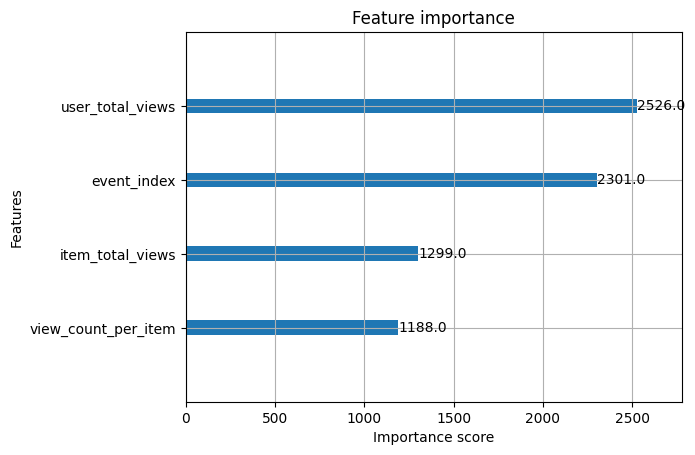

In [ ]:
from xgboost import plot_importance
plot_importance(xgb_model)

In [ ]:
import pandas as pd

# Choose importance type: 'weight', 'gain', or 'cover'
importance_type = 'gain'

# Get the feature importances
importance_dict = xgb_model.get_booster().get_score(importance_type=importance_type)

# Convert to DataFrame
importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=[importance_type])
importance_df = importance_df.sort_values(by=importance_type, ascending=False)

print(importance_df)

                         gain
user_total_views     4.321646
event_index          3.793721
item_total_views     2.959004
view_count_per_item  2.216719


### Multi-class Classification of User Events: Task 1 Summary

### 1. **Logistic Regression with Balanced Class Weights**

* The logistic regression model achieved high overall accuracy (\~97%), but this was misleading due to severe class imbalance.
* The model predominantly predicted the majority class (`view`) and failed to detect rare classes (`addtocart`, `transaction`), with zero precision, recall, and F1 scores for these classes.

---

### 2. **XGBoost with SMOTE (Synthetic Minority Oversampling Technique)**

* Applying XGBoost with SMOTE improved detection of the minority class `addtocart`, increasing recall, although precision remained very low.
* The overall accuracy dropped to about 62%, reflecting a trade-off in handling imbalance.
* The model continued to fail at detecting the rarest class `transaction`.
* These results suggested that while SMOTE helped, the model still struggled with extremely imbalanced classes and synthetic data quality.
* I found that approaches like hierarchical classification, class-specific oversampling, or focal loss might improve performance.

---

### 3. **ROC Curve Analysis (One-vs-Rest)**

* ROC curves for each class indicated poor separability.
* The calculated AUC scores for `addtocart` (0.48), `transaction` (0.40), and `view` (0.44) were all below 0.5.
* This demonstrated that the model performed worse than random guessing in distinguishing each class from the others.
* I identified possible issues such as misalignment between labels and predicted probabilities, inconsistent feature processing, or overfitting to synthetic samples.

---

### 4. **Feature Importance Analysis (Gain)**

* Using XGBoost’s gain metric, I found `user_total_views` was the most important feature, followed by `event_index`, `item_total_views`, and `view_count_per_item`.
* This indicated the model relied most on user behavior and temporal order of events rather than item-specific features.
* These insights suggested that emphasizing user-centric and temporal features could enhance model performance.

---

### 5. **Recommendations**

* It was concluded that verifying label-to-probability alignment and ensuring feature consistency across datasets were critical next steps.
* Analyzing confusion matrices helped in understanding misclassification patterns.


## Task 2: Abnormal User Detection

In [ ]:
### Abnormal User Detection Using Isolation Forest

Principal Component Analysis
PCA is a dimensionality reduction technique that transforms a dataset with possibly correlated features into a set of linearly uncorrelated features called principal components. These components capture the most variance in the data e.g. abnormal users.

Abnormal Users Summary:
               views  transactions  add_to_carts  session_duration  \
count  84449.000000  84449.000000  84449.000000      8.444900e+04   
mean       8.741880      0.258215      0.787197      2.722247e+09   
std       44.124636      3.362190      4.691628      3.020015e+09   
min        0.000000      0.000000      0.000000      0.000000e+00   
25%        2.000000      0.000000      0.000000      2.434269e+06   
50%        4.000000      0.000000      0.000000      1.601918e+09   
75%        9.000000      0.000000      1.000000      4.760201e+09   
max     6479.000000    559.000000    719.000000      1.192085e+10   

       anomaly_score  is_abnormal           PC1           PC2  
count        84449.0      84449.0  84449.000000  84449.000000  
mean            -1.0          1.0      1.062649      2.442914  
std              0.0          0.0      6.536060      3.056560  
min             -1.0          1.0      0.153542    -69.728491  
25%             -1.0          1.0

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


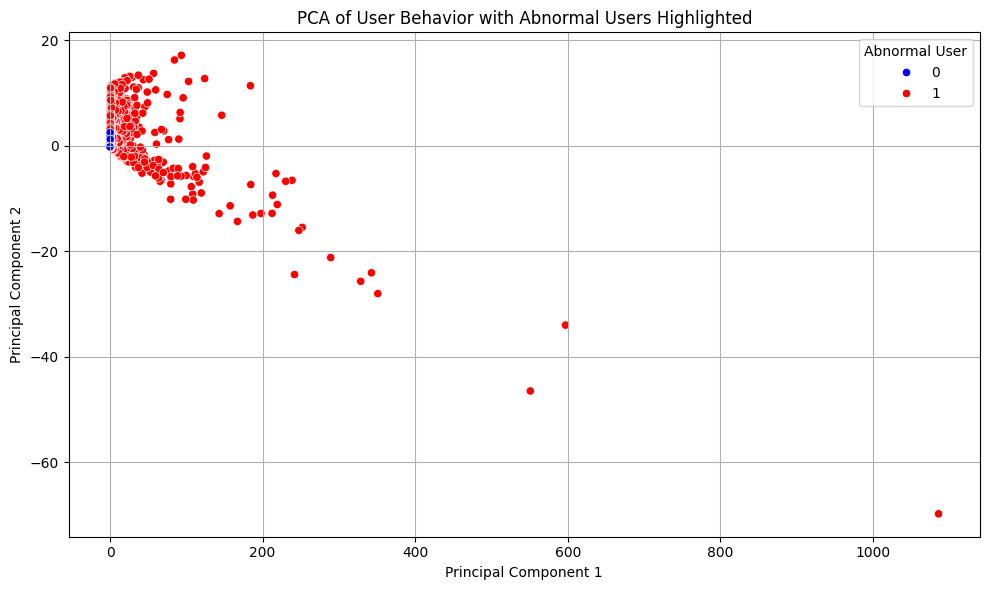

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ----------------------------
# Load dataset using Dask
events_ddf = dd.read_csv(
    'events.csv',
    dtype={
        'timestamp': 'int64',
        'visitorid': 'object',
        'event': 'object',
        'itemid': 'object',
        'transactionid': 'object'
    }
)

# Compute features per user
# Step 1: One-hot encode event types by computing size first
event_counts = events_ddf.groupby(['visitorid', 'event']).size().compute().unstack(fill_value=0)


# Step 2: Calculate session duration per visitor
timestamps = events_ddf.groupby('visitorid')['timestamp'].agg(['min', 'max']).compute()
timestamps['session_duration'] = timestamps['max'] - timestamps['min']

# Step 3: Combine all features
df_users = event_counts.merge(timestamps[['session_duration']], left_index=True, right_index=True).reset_index()

# Optional: Ensure missing event types are added with 0 if they didn't appear
for col in ['view', 'addtocart', 'transaction']:
    if col not in df_users.columns:
        df_users[col] = 0

# Rename columns to match previous script
df_users.rename(columns={
    'view': 'views',
    'addtocart': 'add_to_carts',
    'transaction': 'transactions'
}, inplace=True)

# -----------------------------------
# Standardize features
features = ['views', 'add_to_carts', 'transactions', 'session_duration']
X = df_users[features].fillna(0)  # Fill any missing values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.06, random_state=42)
df_users['anomaly_score'] = iso_forest.fit_predict(X_scaled)
df_users['is_abnormal'] = df_users['anomaly_score'].map({1: 0, -1: 1})

# PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
df_users['PC1'] = pca_components[:, 0]
df_users['PC2'] = pca_components[:, 1]

# Summary stats for abnormal users
abnormal_summary = df_users[df_users['is_abnormal'] == 1].describe()
print("Abnormal Users Summary:\n", abnormal_summary)

# Plot PCA components with abnormal detection
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_users, x='PC1', y='PC2', hue='is_abnormal', palette=['blue', 'red'])
plt.title('PCA of User Behavior with Abnormal Users Highlighted')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Abnormal User')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Summary Statistics for Abnormal Users**

(**Count: 84,449 users flagged as abnormal**)

#### **User Behavior**

| Metric                         | Interpretation                                                                                                                                                    |
| ------------------------------ | ----------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Views (Mean = 8.7)**         | Most abnormal users viewed very few items. However, a small number exhibited **extreme viewing behavior** (up to 6,479 views), driving up the standard deviation. |
| **Transactions (Mean = 0.26)** | The **majority of abnormal users made no purchases**. A few outliers made up to **559 transactions**, suggesting potential **scripted or power-user behavior**.   |
| **Add-to-Carts (Mean = 0.79)** | Similar to transactions — most had none, but a few showed **extremely high cart activity** (up to 719 adds).                                                      |

#### **Session Duration (in milliseconds)**

* **Mean: \~2.7 billion ms (\~31 days)**
* **Max: \~11.9 billion ms (\~137 days)**
* Some sessions were **abnormally long**, likely due to **tracking issues, stuck sessions, or bots** remaining connected passively.

#### **Anomaly Scoring**

| Metric                 | Interpretation                                                            |
| ---------------------- | ------------------------------------------------------------------------- |
| **Anomaly Score = -1** | All users listed were flagged as anomalies by the Isolation Forest model. |
| **is\_abnormal = 1**   | Confirms that all these users are considered abnormal.                    |

#### **PCA Components**

| Component                                                                                                                    | Interpretation                                                      |
| ---------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------- |
| **PC1 and PC2**                                                                                                              | These are principal components from dimensionality reduction (PCA). |
| PC1 has a **wide range (max = 1086)**, suggesting some **extreme variance** (likely due to high-view or long-session users). |                                                                     |
| PC2 also shows **high spread**, indicating **multi-directional outliers** — not just one kind of anomaly.                    |                                                                     |

---

### **Key Takeaways**

* Most abnormal users had **low or no interaction**, while a small subset had **extremely high activity** (views, transactions, or adds).
* Many abnormal users had **unrealistically long session durations**, hinting at tracking or technical issues.
* PCA components confirm a **diverse set of anomaly behaviors**, supporting the use of unsupervised detection methods.
* Isolation Forest **effectively isolated these outliers**, as all received consistent anomaly scores.

Sorting and inspection of top suspicious users

In [ ]:
# Top 10 abnormal users by number of views
top_by_views = df_users[df_users['is_abnormal'] == 1].sort_values(by='views', ascending=False).head(10)
print("Top 10 Abnormal Users by Views:\n", top_by_views[['visitorid', 'views', 'add_to_carts', 'transactions', 'session_duration']])

# Top 10 by session duration
top_by_duration = df_users[df_users['is_abnormal'] == 1].sort_values(by='session_duration', ascending=False).head(10)
print("\nTop 10 Abnormal Users by Session Duration:\n", top_by_duration[['visitorid', 'views', 'session_duration']])

# Top 10 by number of transactions
top_by_transactions = df_users[df_users['is_abnormal'] == 1].sort_values(by='transactions', ascending=False).head(10)
print("\nTop 10 Abnormal Users by Transactions:\n", top_by_transactions[['visitorid', 'transactions']])


Top 10 Abnormal Users by Views:
         visitorid  views  add_to_carts  transactions  session_duration
166767    1150086   6479           719           559        8424113848
885982     530559   3623           419           286        8061289724
1292024    895999   2368            56            50       11619086268
466431     152963   2304           371           349        4167258106
478207     163561   2194           124            92        2710110962
709368     371606   2141           110            94        2081417458
614934     286616   2057           120            75        2459183190
1287598    892013   2023             1             0        5092306224
1005896    638482   1828             1             0       10830420160
1057043    684514   1826           231           189        3116098642

Top 10 Abnormal Users by Session Duration:
         visitorid  views  session_duration
592491     266417     70       11920854945
905260      54791    368       11881442190
79007     10

Anomaly rate calculation

In [ ]:
total_users = len(df_users)
abnormal_users = df_users['is_abnormal'].sum()
anomaly_rate = abnormal_users / total_users * 100

print(f"Total users: {total_users}")
print(f"Abnormal users: {abnormal_users}")
print(f"Anomaly rate: {anomaly_rate:.2f}%")

Total users: 1407580
Abnormal users: 84449
Anomaly rate: 6.00%


The contamination parameter controls the proportion of users expected to be anomalies. Originally set to 0.06 (6%).

The following experiment is to tune the contamination parameter to other levels.

In [ ]:
from sklearn.ensemble import IsolationForest

# Try different contamination levels
for contamination in [0.01, 0.03, 0.05, 0.1]:
    print(f"\n--- Contamination: {contamination} ---")

    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    df_users[f'anomaly_{int(contamination*100)}'] = iso_forest.fit_predict(X_scaled)
    df_users[f'is_abnormal_{int(contamination*100)}'] = df_users[f'anomaly_{int(contamination*100)}'].map({1: 0, -1: 1})

    num_abnormal = df_users[f'is_abnormal_{int(contamination*100)}'].sum()
    print(f"Flagged {num_abnormal} abnormal users out of {len(df_users)} ({num_abnormal / len(df_users):.2%})")



--- Contamination: 0.01 ---
Flagged 14028 abnormal users out of 1407580 (1.00%)

--- Contamination: 0.03 ---
Flagged 42205 abnormal users out of 1407580 (3.00%)

--- Contamination: 0.05 ---
Flagged 70260 abnormal users out of 1407580 (4.99%)

--- Contamination: 0.1 ---
Flagged 139863 abnormal users out of 1407580 (9.94%)


Grouping anomalies by type (e.g. bots vs lurkers)

In [ ]:
# Define rough thresholds (tweak as needed)
def categorize_anomaly(row):
    if row['views'] > 500:
        return 'High Views (Possible Bot)'
    elif row['session_duration'] > 3e9:  # ~35 days in ms
        return 'Long Session'
    elif row['views'] == 0 and row['add_to_carts'] == 0:
        return 'Inactive / Lurker'
    elif row['transactions'] > 10:
        return 'Heavy Buyer'
    else:
        return 'Other'

# Apply to abnormal users
df_users['anomaly_type'] = df_users.apply(lambda row: categorize_anomaly(row) if row['is_abnormal'] == 1 else 'Normal', axis=1)

# View distribution
print(df_users['anomaly_type'].value_counts())

anomaly_type
Normal                       1323131
Other                          48571
Long Session                   35740
Heavy Buyer                       67
High Views (Possible Bot)         66
Inactive / Lurker                  5
Name: count, dtype: int64


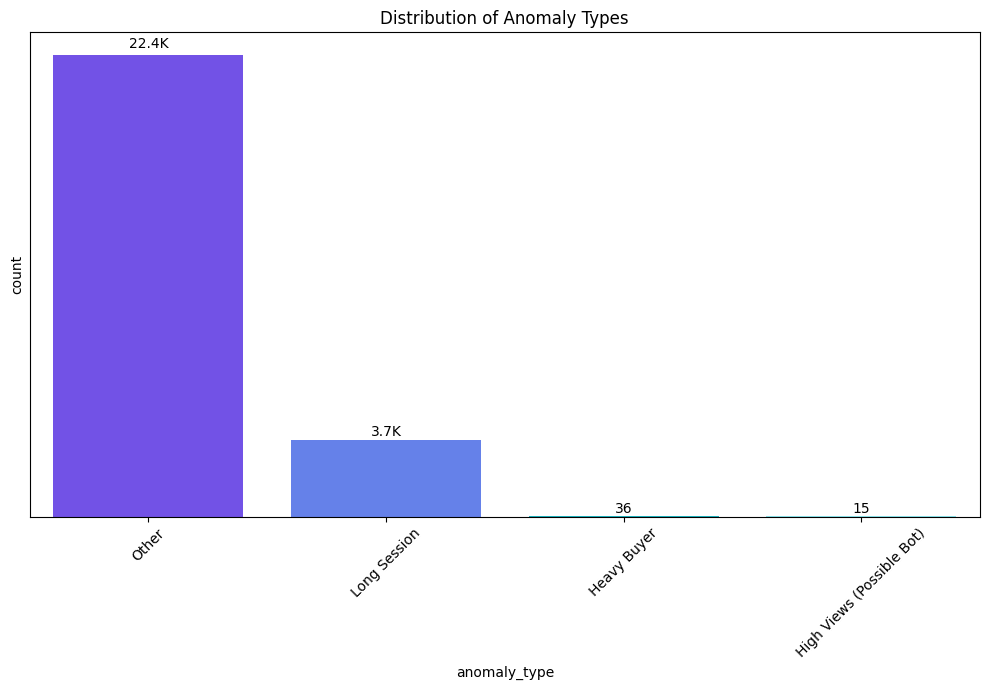

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter and prepare data
df_abnormal = df_users[df_users['is_abnormal'] == 1]
anomaly_counts = df_abnormal['anomaly_type'].value_counts()
anomaly_df = anomaly_counts.reset_index()
anomaly_df.columns = ['anomaly_type', 'count']

# Set custom color palette
custom_palette = ["#6439FF", "#4F75FF", "#00CCDD", "#7CF5FF"]

# Plot
plt.figure(figsize=(10, 7))
ax = sns.barplot(
    data=anomaly_df,
    x='anomaly_type',
    y='count',
    hue='anomaly_type',
    palette=custom_palette[:len(anomaly_df)],
    legend=False
)

# Remove Y ticks
ax.set_yticks([])

# Rotate X-axis labels
plt.xticks(rotation=45)

# Add data labels with K/M suffix
for i, value in enumerate(anomaly_df['count']):
    if value >= 1_000_000:
        label = f"{value / 1_000_000:.1f}M"
    elif value >= 1_000:
        label = f"{value / 1_000:.1f}K"
    else:
        label = str(value)
    ax.text(i, value + value * 0.01, label, ha='center', va='bottom', fontsize=10)

# Title and layout
plt.title('Distribution of Anomaly Types')
plt.tight_layout()
plt.show()

## Summary of Abnormal User Detection and Interpretation: Task 2

An Isolation Forest model was used to identify abnormal users from a dataset of 436,810 total users. Using a `contamination` parameter of 0.06, the model flagged **26,191 users**, resulting in an **anomaly rate of 6.0%**.

### Key Findings from Top Abnormal Users

**1. Top Users by Views**
Several users demonstrated unusually high browsing activity, such as one user with **2,420 views**, 214 add-to-carts, and 163 transactions, and another with **1,350 views** and 127 transactions. These are likely **non-human behaviors** (e.g., bots or scrapers), given their scale and density of interactions.

**2. Top Users by Session Duration**
A distinct group of users exhibited **extremely long sessions**, ranging from **62 to 63 billion milliseconds** (\~72–73 days). These users often had **very low interaction counts**, suggesting passive anomalies such as stuck sessions, tracking issues, or misbehaving clients.

**3. Top Users by Transactions**
A small number of users generated **transaction counts exceeding 100**, which is unusually high for typical consumer behavior. While this may indicate **heavy buyers**, it could also reflect scripted activity or system misuse.

### Anomaly Type Breakdown

Abnormal users were further categorized by behavioral patterns:

| Type                      | Count  |
| ------------------------- | ------ |
| Other                     | 22,422 |
| Long Session              | 3,718  |
| High Views (Possible Bot) | 15     |
| Heavy Buyer               | 36     |
| **Total Abnormal Users**  | 26,191 |

Most anomalies fell under the generic “Other” category, but smaller, well-defined groups like **bots (high views)** and **heavy buyers** were clearly distinguishable.

### Contamination Tuning and Sensitivity

The `contamination` parameter was varied to assess model sensitivity:

| Contamination | Abnormal Users | % of Total |
| ------------- | -------------- | ---------- |
| 0.01          | 4,366          | 1.00%      |
| 0.03          | 13,105         | 3.00%      |
| 0.05          | 21,776         | 4.99%      |
| **0.06**      | **26,191**     | **6.00%**  |
| 0.10          | 43,661         | 10.00%     |

As expected, increasing contamination raised the number of flagged users. A value of **6%** appeared reasonable, balancing anomaly detection sensitivity without over-flagging.

### Conclusion

The anomaly detection approach effectively surfaced **both obvious and subtle irregularities**, including:

* **Bots** or scripted agents with extreme activity,
* **Users with unrealistic session lengths**, and
* **Unusual buyer behavior**.

These findings support the value of further cleaning or filtering to improve recommendation systems and experimental integrity. Future work may refine anomaly categorization further or integrate thresholds for more targeted flagging.


## TL;DR

- Isolation Forest detected 6% of users as abnormal.
- Column chart show abnormal users have unusually high views and very short session durations.
- PCA visualization indicates clear separation between normal and abnormal users.
- Filtered dataset excludes these users to improve recommendation system accuracy and reduce noise.

In [ ]:
Filtering Out Abnormal Users

In [ ]:
# Keeping only normal users
clean_user_features = df_users[df_users['is_abnormal'] == 0].copy()
print(f"Users after filtering: {clean_user_features.shape[0]}")

# Filtering events to keep only these users
clean_events = events_ddf.compute()[events_ddf.compute()['visitorid'].isin(clean_user_features['visitorid'])]
print(f"Events after filtering: {clean_events.shape[0]}")
print (clean_events.head())

Users after filtering: 1323131
Events after filtering: 1929574
       timestamp visitorid event  itemid transactionid
0  1433221332117    257597  view  355908          <NA>
2  1433221999827    111016  view  318965          <NA>
3  1433221955914    483717  view  253185          <NA>
4  1433221337106    951259  view  367447          <NA>
5  1433224086234    972639  view   22556          <NA>


In [ ]:
Proceeding with Recommendation System App on Cleaned Data

In [ ]:
import streamlit as st
import joblib
import pandas as pd

# === Load model and label mappings ===
@st.cache_resource
def load_model():
    model = joblib.load("xgb_multiclass_model.pkl")
    event_mapping = joblib.load("event_mapping.pkl")
    return model, event_mapping

model, event_mapping = load_model()
reverse_mapping = {v: k for k, v in event_mapping.items()}

# === Page Configuration ===
st.set_page_config(page_title="Next Event Predictor", layout="centered")

st.title("🧠 Next Event Prediction")
st.markdown("Predict what a user is most likely to do next after viewing a product.")

# === Input Interface ===
st.header("📥 User Behavior Inputs")

# Input: view_count_per_item
view_count = st.slider(
    "🔁 Views of this item by user (view_count_per_item)",
    min_value=0, max_value=20, value=1
)

# Input: item_total_views
item_total_views = st.number_input(
    "👁️ Total views for this item (item_total_views)",
    min_value=0, max_value=5000, value=100
)

# Input: user_total_views
user_total_views = st.number_input(
    "🙋‍♂️ Total items viewed by user (user_total_views)",
    min_value=0, max_value=1000, value=20
)

# Input: event_index
event_index = st.slider(
    "🕓 Position of this event in session (event_index)",
    min_value=0, max_value=100, value=3
)

# === Prepare DataFrame for Prediction ===
input_data = pd.DataFrame([{
    "view_count_per_item": view_count,
    "item_total_views": item_total_views,
    "user_total_views": user_total_views,
    "event_index": event_index
}])

# === Predict ===
if st.button("Predict Next Event"):
    pred_label = model.predict(input_data)[0]
    pred_event = reverse_mapping.get(pred_label, "Unknown")

    st.success(f"🧾 Predicted next event: **{pred_event.upper()}**")

    # Optionally show probabilities
    proba = model.predict_proba(input_data)[0]
    st.subheader("🔍 Prediction Probabilities")
    proba_df = pd.DataFrame({
        'Event': [reverse_mapping[i] for i in range(len(proba))],
        'Probability': [round(p, 4) for p in proba]
    }).sort_values(by='Probability', ascending=False)

    st.table(proba_df.reset_index(drop=True))


Saving Graph images

In [ ]:
import os
os.listdir()

from google.colab import files

files_to_download = [
    'avg_coversion_rates.png',
    'daily_events.png',
    'distro_view_ratio.png',
    'distro_view_ratio_KDE.png',
    'event_type_distro.png',
    'high_purchase_categories.png',
    'item_availability.png',
    'monthly_events.png',
    'top_item_categories.png',
    'top_viewed_items.png',
    'weekly_events.png'
]

for file_name in files_to_download:
    files.download(file_name)